# Rate of Model Collapse in Recursive Training

This Colab file contains the code for all the simulations discussed in the paper, 'Rate of Model Collapse in Recursive Training.' In this study, we analyze the rate of model collapse during recursive training in Bernoulli, Poisson, and Gaussian settings. This analysis was also extended to n-gram language models and Gaussian Mixture Models.


##Requirements

This section includes the essential libraries needed to run the code from the paper, *Rate of Model Collapse in Recursive Training*.


In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as sopt
import random
from tqdm import tqdm
rng = np.random.default_rng()

## Bernoulli & Normal Model Simulation Plots

Simulation plots of multiple trajectories of recursive training across generations in the Guassian model, corresponding to Figure 2(a) in the paper.

100%|██████████| 62500/62500 [00:04<00:00, 14069.74it/s]


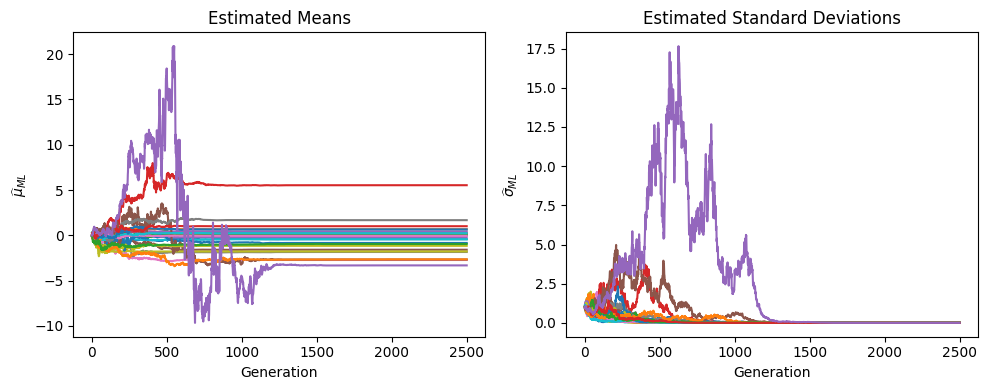

In [ ]:
# Initial parameters
mu_0 = 0
sigma_0 = 1

def generate_normal_samples(mu, sigma, n):
    '''
    mu: mean
    sigma: standard deviation
    n: number of samples
    '''
    return np.random.normal(mu, sigma, n)

def ml_estimate(samples):
    '''
    samples: array of samples
    '''
    return np.mean(samples), np.std(samples, ddof=1)

n = 100  # Number of samples per generation
num_trajectories = 25   # Number of different trajectories to generate
num_generations = 2500  # Number of generations to simulate

means, stds = [], []
pbar = tqdm(total=num_trajectories * num_generations)


# Generate each trajectory

for _ in range(num_trajectories):
    mu, sigma = mu_0, sigma_0
    mean_arr, std_arr = [], [] # Initialize the array with the initial probability

    for _ in range(num_generations):
       # Generate samples and estimate the new probability
        samples = generate_normal_samples(mu, sigma, n)
        mu, sigma = ml_estimate(samples)
        mean_arr.append(mu)
        std_arr.append(sigma)
        pbar.update(1)

    means.append(mean_arr)
    stds.append(std_arr)

pbar.close()

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

for mean_arr in means:
    ax[0].plot(mean_arr)
for std_arr in stds:
    ax[1].plot(std_arr)

ax[0].set_xlabel('Generation')
ax[1].set_xlabel('Generation')
ax[0].set_ylabel(r'$\widehat{\mu}_{ML}$')
ax[1].set_ylabel(r'$\widehat{\sigma}_{ML}$')
ax[0].set_title('Estimated Means')
ax[1].set_title('Estimated Standard Deviations')

plt.tight_layout()
plt.savefig('normal_simulations.png')
plt.savefig('normal_simulations.pdf')
plt.show()


Simulation plots of multiple trajectories of recursive training across generations in the Bernoulli models, corresponding to Figure 2(b) in the paper.

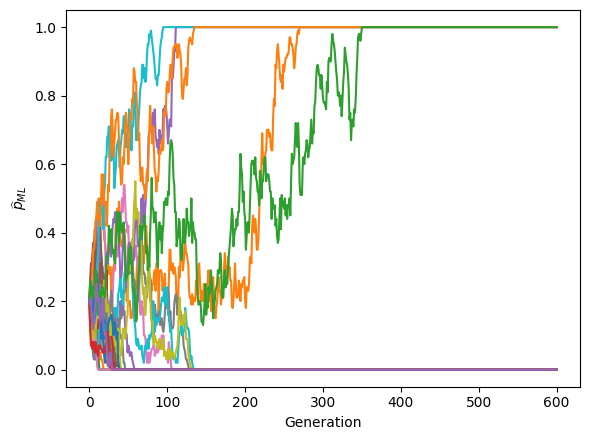

In [ ]:
# Function to generate n iid Bernoulli samples with a success probability p
def generate_bernoulli_samples(n, p):
    '''
    n: number of samples
    p: success probability
    '''
    return np.random.binomial(1, p, n)

# Function to estimate the probability p from the samples
def estimate_p(samples):
    '''
    samples: array of Bernoulli samples
    '''
    return np.mean(samples)

# Parameters
num_generations = 600  # Number of generations to simulate
p_0 = 0.2  # Initial probability of success
n = 100  # Number of samples per generation
num_trajectories = 25  # Number of different trajectories to generate

plt.figure(figsize=(6, 4.5))

# Generate and plot each trajectory
for _ in range(num_trajectories):
    probab_array = [p_0]
    p = p_0
    for _ in range(num_generations):
        samples = generate_bernoulli_samples(n, p)
        p = estimate_p(samples)
        probab_array.append(p)
    # Plot the current trajectory
    plt.plot(probab_array)

# Plotting
plt.xlabel('Generation')
plt.ylabel(r'$\widehat{p}_{ML}$')
plt.tight_layout()
plt.savefig('bernoulli_sim.png')
plt.show()

## Bernoulli Model Bounds

**Comparison of Theoretical Bounds and Empirical Observations in the Bernoulli Model**

This section presents a comparison between the theoretical bounds and empirical observations of the probability $\Pr(P_k \neq 0)$ at a specific generation in a Bernoulli recursive training process. In this analysis, we use $n$ samples at each generation and vary the initial success probabilities $(p_0)$.



> **Theorem 1: Bernoulli Recursive Training Process**



For the Bernoulli recursive training process defined in Section 3.1 in the paper, we have $\Pr(P_k \ne 0)$ lies in :

\begin{align*}
\left[ 1 - \exp(-n p_0 g_k) , 1 - \left(1 - 3np_0^2 - 3 k p_0 \right) \exp(- n p_0 g_k )
  \right]
\end{align*}

where $ g_k \triangleq g^{\circ k}(\infty) \in \left[\frac{1}{k}, \frac{3}{k}\right]$ with $g(x) = 1 - e^{-x}$ and $g^{\circ k}$ denotes $g$ composed $k$ times.


In [ ]:
def get_equidistant_points(data, num_points=10):
    '''
    Used to sample points from data for plotting purposes

    data: array of data points
    num_points: number of points to return
    '''
    data = np.asarray(data)
    if num_points > len(data):
        raise ValueError("num_points must not exceed the number of elements in data.")

    indices = np.linspace(0, len(data) - 1, num=num_points, dtype=int)

    return data[indices]


def plot_bernoulli_bounds(p_0, n, num_generations, collapse_indicator = [0]):
    '''
    Given an initial probability p_0, this function plots the simulations, provided upper and lower bounds of the probability of not collapsing to zero for the Bernoulli model.


    p_0: initial probability of success
    n: number of samples per generation
    ng: number of generations to simulate
    collapse_indicator: array of probabilities to collapse to

    returns:
    collapse_array: simulated array of probabilities
    our_lower: array of our lower bounds
    our_upper: array of our upper bounds
    seddik_lower: array of Seddick et al. lower bounds
    seddik_upper: array of Seddick et al. upper bounds
    error_bars: array of error bars for the probabilities

    '''

    num_generations = num_generations
    n = n
    num_trajectories = 5000 #Number of Trajectories to Simulate
    final_array = []

    def generate_samples(n,p):
        return np.random.binomial(1, p, n)

    def estimate_p(samples):
        return np.mean(samples)

    def our_bounds(n = n, p_0 = p_0, num_generations = num_generations):
        '''
        Function returning our Upper and Lower Bounds. This helps in plotting the bounds provided in Theorem 1.
        '''
        gok = []
        def g(x):
            return 1- np.exp(-x)
        gok.append(1)
        for i in range(1,num_generations):
            gok.append(g(gok[-1]))

        if len(collapse_indicator) == 1:
          lower_bound = [(1-np.exp(-n*p_0*g_k))for g_k in gok]
        elif len(collapse_indicator) == 2:
          lower_bound = [(1-(np.exp(-n*p_0*g_k)+np.exp(-n*(1-p_0)*g_k)))for g_k in gok]

        if len(collapse_indicator) == 2:
          upper_bound = [1-((np.exp(-n*p_0* g_k))*max((1-3*n*(p_0**2)- 3*(k+1)*p_0), 0)+(np.exp(-n*(1-p_0)* g_k))*max((1-3*n*((1-p_0)**2)- 3*(k+1)*(1-p_0)), 0)) for k,g_k in enumerate(gok)]
        elif len(collapse_indicator) == 1:
          upper_bound = [1-((np.exp(-n*p_0* g_k))*max((1-3*n*(p_0**2)- 3*(k+1)*p_0), 0)) for k,g_k in enumerate(gok)]


        return lower_bound, upper_bound,

    def seddik_bounds(n = n, p_0 = p_0, num_generations = num_generations):
        '''
        Function to calculate the bounds provided in Seddick et al.
        '''
        generations = np.array(range(1, num_generations+1))
        lower_bounds = 4*p_0*(1-p_0)*((1-(1/n))**generations)
        upper_bounds = 2*n*p_0*(1-p_0)*((1-(1/n))**generations)
        for i,num in enumerate(upper_bounds):
            if num >= 1:
                upper_bounds[i] = 1

        return lower_bounds, upper_bounds


    #Simulating the Trajectories
    for _ in range(num_trajectories):
        probab_array = [p_0]
        p = p_0
        for _ in range(num_generations):
            samples = generate_samples(n,p)
            p = estimate_p(samples)
            probab_array.append(p)
        final_array.append(probab_array)


    final_array = np.array(final_array)
    collapse_array = []

    #Calculating the collapse probability at a given generation from trajectories
    for i in range(1,num_generations+1):
        count = 0
        for num in final_array[:,i]:
            if num not in collapse_indicator:
                count += 1
        collapse_array.append(count/(num_trajectories))

    our_lower, our_upper = our_bounds()
    seddik_lower, seddik_upper = seddik_bounds()
    error_bars = [np.sqrt((p * (1 - p)) / num_trajectories) for p in collapse_array]

    return collapse_array, our_lower, our_upper, seddik_lower, seddik_upper, error_bars

Plotting $\Pr(P_k \ne 0)$

In [ ]:
'''
Each tuple in the below array represents (initial probability, number of samples, number of generations).

For example,

p_0_n_ng_arr = [(0.5,10,100)] plots simulations and the theoretical bounds for the case where p_0 = 0.5, n = 10, num_generations = 100.

'''
p_0_n_ng_arr = [(0.001,10000, 50),(0.01,100, 50)]

collapse_array, error_bars = [],[]
our_lower, our_upper = [],[]

for p_0,n,ng in p_0_n_ng_arr:
    output =  plot_bernoulli_bounds(p_0,n, ng)
    collapse_array.append(output[0])
    our_lower.append(output[1])
    our_upper.append(output[2])
    error_bars.append(output[5])

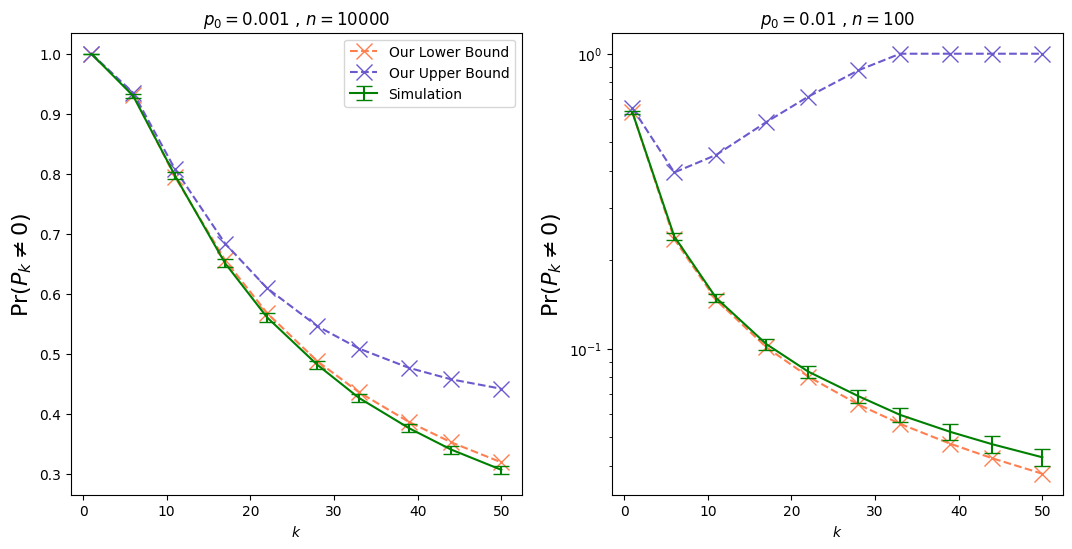

In [ ]:
#Plotting
fig, axes = plt.subplots(1, len(p_0_n_ng_arr), figsize=(6.4*len(p_0_n_ng_arr),6))

color1 = '#6a5acd'
color2 = '#ff7f50'

x_axes = []
for _,_,ng in p_0_n_ng_arr:
    x_axes.append(get_equidistant_points(np.array(range(1,ng+1))))

for i,ax in enumerate(axes):
    ax.plot(x_axes[i], get_equidistant_points(our_lower[i]),'--',marker='x',  ms = 12, color=color2 , label = 'Our Lower Bound' )
    ax.plot(x_axes[i], get_equidistant_points(our_upper[i]),'--', marker='x',  ms = 12, color=color1,  label = 'Our Upper Bound')
    ax.errorbar(x_axes[i], get_equidistant_points(collapse_array[i]), yerr = get_equidistant_points(error_bars[i]), capsize = 6, color = 'green', label = r'Simulation')

    ax.set_xlabel(r'$k$',)
    ax.set_ylabel(r'$\Pr(P_k \neq 0)$',fontsize = 16)

for i,ax in enumerate(axes):
    ax.set_title(r'$p_0 =$'+f'{p_0_n_ng_arr[i][0]}'+r' , $n =$'+f'{p_0_n_ng_arr[i][1]}',)

axes[1].set_yscale('log')

handles, labels = ax.get_legend_handles_labels()
axes[0].legend(labels, loc = 'upper right', ncol = 1,)
for ax in axes:
    ax.tick_params(axis='both', which='major',)
plt.savefig('bernoulli_our_bounds.png')
plt.savefig('bernoulli_our_bounds.pdf')
plt.show()

We now plot $\Pr(P_k \notin \{0, 1\})$ and compare with bounds given by Seddick et al.



> **Extension of Theorem 1**

We get that
\begin{align*}
1 - \left( \exp(-n (p_0) g_k) +  \exp(- n (1-p_0) g_k ) \right) \leq \Pr(P_k \notin \{0, 1\}),
\end{align*}
and
\begin{align*}
\Pr(P_k \notin \{0, 1\}) \leq 1 - \left(   \max\left(1 - 3np^2_0 - 3 k p_0, 0 \right) e^{- n p_0 g_k }  +   \max\left(1 - 3n(1-p_0)^2 - 3 k (1-p_0), 0 \right) e^{- n (1-p_0) g_k }\right)
\end{align*}

> **Seddick Bounds**



For Bernoulli distributions, Seddick et al. implies that $\Pr(P_k \notin \{0, 1\})$ lies in
\begin{align*}
\left[ 4p_0(1-p_0) \left( 1 - \frac{1}{n}\right)^k,    2np_0(1-p_0)  \left( 1 - \frac{1}{n}\right)^k \right]
\end{align*}



In [ ]:
'''
Each tuple in the below array represents (initial probability, number of samples, number of generations).

For example,

p_0_n_ng_arr = [(0.5,10,100)] plots simulations and the theoretical bounds for the case where p_0 = 0.5, n = 10, num_generations = 100.

'''
p_0_n_ng_arr = [(0.001,10000, 50),(0.01, 100, 50)]


collapse_array, error_bars = [],[]
our_lower, our_upper = [],[]
seddik_lower, seddik_upper = [],[]

for p_0,n,ng in p_0_n_ng_arr:
    output =  plot_bernoulli_bounds(p_0,n, ng, collapse_indicator = [0,1]) #Just changing the collapse indicator is sufficient to plot Pr(P_k != {0,1})
    collapse_array.append(output[0])
    our_lower.append(output[1])
    our_upper.append(output[2])
    seddik_lower.append(output[3])
    seddik_upper.append(output[4])
    error_bars.append(output[5])

0.317


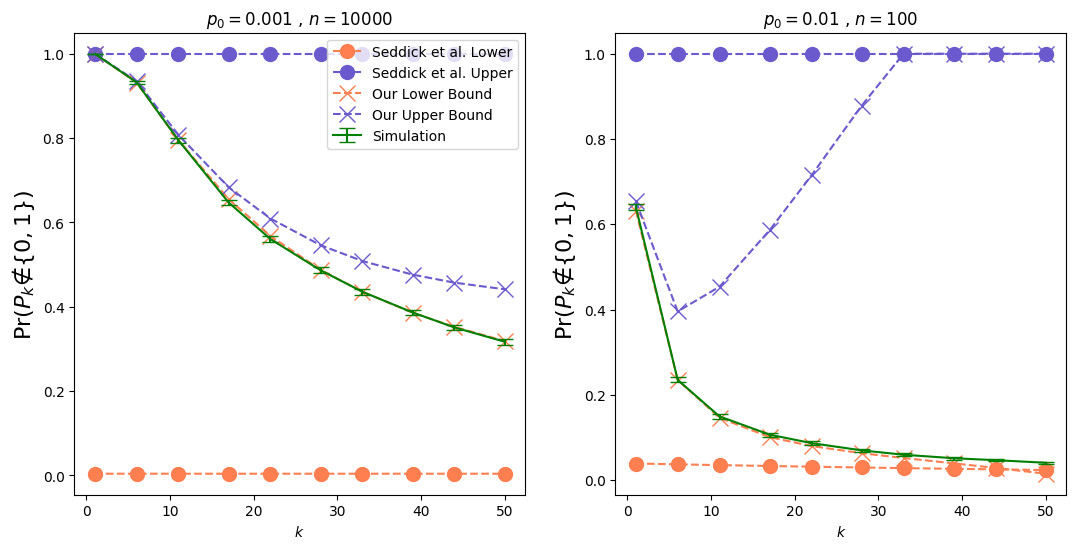

In [ ]:
#Plotting
fig, axes = plt.subplots(1, len(p_0_n_ng_arr), figsize=(6.4*len(p_0_n_ng_arr),6))
color1 = '#6a5acd'
color2 = '#ff7f50'

x_axes = []
for _,_,ng in p_0_n_ng_arr:
    x_axes.append(get_equidistant_points(np.array(range(1,ng+1))))

for i,ax in enumerate(axes):
    ax.plot(x_axes[i], get_equidistant_points(seddik_lower[i]), marker='o', markersize=10, linestyle='--', color = color2, label = 'Seddick et al. Lower')
    ax.plot(x_axes[i], get_equidistant_points(seddik_upper[i]), marker='o', markersize=10, linestyle='--', color = color1, label = 'Seddick et al. Upper')
    ax.plot(x_axes[i], get_equidistant_points(our_lower[i]),'--', marker='x',  ms = 12, color=color2 , label = 'Our Lower Bound' )
    ax.plot(x_axes[i], get_equidistant_points(our_upper[i]),'--', marker='x',  ms = 12, color=color1,  label = 'Our Upper Bound')
    ax.errorbar(x_axes[i], get_equidistant_points(collapse_array[i]), yerr = get_equidistant_points(error_bars[i]), capsize = 6, color = 'green', label = r'Simulation')

    ax.set_xlabel(r'$k$',)
    ax.set_ylabel(r'$\Pr(P_k \notin \{0, 1\})$',fontsize = 16)

for i,ax in enumerate(axes):
    ax.set_title(r'$p_0 =$'+f'{p_0_n_ng_arr[i][0]}'+r' , $n =$'+f'{p_0_n_ng_arr[i][1]}',)

# axes[1].set_yscale('log')

handles, labels = ax.get_legend_handles_labels()
axes[0].legend(labels, loc = 'upper right', ncol = 1,)
for ax in axes:
    ax.tick_params(axis='both', which='major',)
plt.savefig('bernoulli_our_bounds.png')
plt.savefig('bernoulli_our_bounds.pdf')
plt.show()

## Poisson Sampling Experiments

**Comparison of Theoretical and Empirical Observations in the Poisson Model**

This section presents a comparison between the theoretical bounds and empirical observations of the probability $\Pr(\Lambda_k \neq 0)$ at a specific generation in a poisson recursive training process. In this analysis, we use $n$ samples at each generation and vary the initial arrival rate $(\lambda_0)$.



> **Theorem 2: Poisson Recursive Training Process**


For the Poisson recursive training process defined in Section 3.2 of the paper,
\begin{equation*}
    \text{Pr}(\Lambda_k\ne0)=1-e^{-n\lambda_0 g_k}\in [1 - e^{-\frac{n\lambda_0}{k}},1 - e^{-\frac{3n\lambda_0}{k}}],
\end{equation*}

where $ g_k \triangleq g^{\circ k}(\infty) \in \left[\frac{1}{k}, \frac{3}{k}\right]$ with $g(x) = 1 - e^{-x}$ and $g^{\circ k}$ denotes $g$ composed $k$ times. This implies that the parameter $\lambda$ in the Poisson$(\lambda)$ model collapses to $0$ almost surely under recursive training.




In [ ]:
def get_equidistant_points(data, num_points=10):
    '''
    Used to sample points from data for plotting purposes

    data: array of data points
    num_points: number of points to return
    '''
    data = np.asarray(data)
    if num_points > len(data):
        raise ValueError("num_points must not exceed the number of elements in data.")

    indices = np.linspace(0, len(data) - 1, num=num_points, dtype=int)

    return data[indices]

def plot_poisson_bounds(lambda_0, ax):
    '''
    Given an initial arrival rate lambda_0, this function plots the simulations, provided expectation of the survival probability for the Probability model.

    lambda_0: initial arrival rate
    ax: axis to plot on

    '''
    num_generations = 500
    n = 10
    num_trajectories = 5000

    final_array = []

    def generate_samples(n,lam):
        return np.random.poisson(lam, n)

    def estimate_p(samples):
        return np.mean(samples)

    def our_bound(n = n, lambda_0 = lambda_0, num_generations = num_generations):
        gok = []
        def g(x):
            return 1- np.exp(-x)
        gok.append(1)
        for i in range(1,num_generations):
            gok.append(g(gok[-1]))

        lower_bound = [(1-np.exp(-n*lambda_0*g_k))for g_k in gok]

        return lower_bound

    for _ in range(num_trajectories):
        probab_array = [lambda_0]
        p = lambda_0
        for _ in range(num_generations):
            samples = generate_samples(n,p)
            p = estimate_p(samples)
            probab_array.append(p)
        final_array.append(probab_array)


    final_array = np.array(final_array)

    collapse_array = []

    for i in range(1,num_generations+1):
        count = 0
        for num in final_array[:,i]:
            if num != 0:
                count += 1
        collapse_array.append(count/(num_trajectories))


    our_estimate= our_bound()
    error_bars = [np.sqrt((p * (1 - p)) / num_trajectories) for p in collapse_array]

    color1 = '#6a5acd'
    color2 = '#ff7f50'
    x_axis = get_equidistant_points(range(1,num_generations+1))

    ax.errorbar(x_axis, get_equidistant_points(collapse_array), yerr = get_equidistant_points(error_bars), capsize = 4, color = 'green', label = r'Simulation')

    ax.plot(x_axis, get_equidistant_points(our_estimate),'--',marker='^', color=color2 , label = r'Our Result' )
    ax.set_yscale('log')

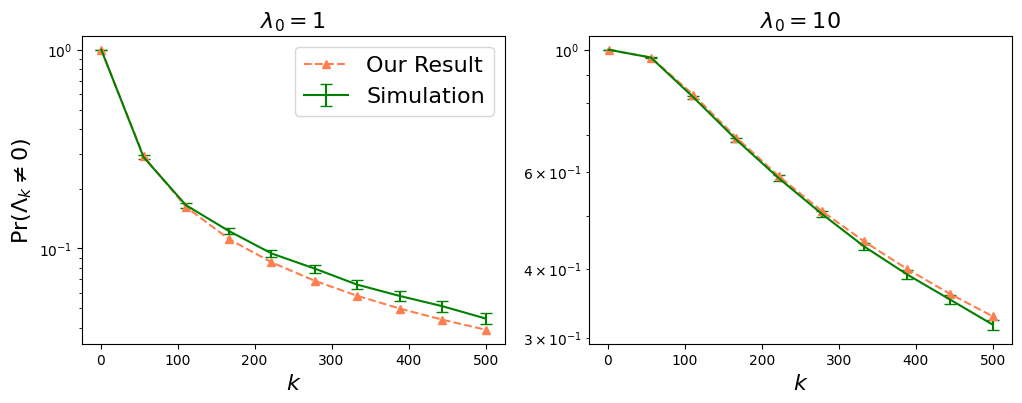

In [ ]:
'''
We plot the simulation and the expected value for each element (represents initial arrival rate) in the below array
'''
lambda_0_arr = [1,10]
fig, axes = plt.subplots(1, len(lambda_0_arr), figsize=(6*len(lambda_0_arr),4))


#Simulation and Plotting
for lambda_0, ax in zip(lambda_0_arr,axes):
    plot_poisson_bounds(lambda_0,ax)

for i,ax in enumerate(axes):
    ax.set_title(r'$\lambda_0=$'+f'{lambda_0_arr[i]}')

handles, labels = ax.get_legend_handles_labels()
axes[0].legend(fontsize = 16)
for i,ax in enumerate(axes):
    ax.tick_params(axis='both', which='both', labelsize=10)
    ax.set_title(r'$\lambda_0=$'+f'{lambda_0_arr[i]}', fontsize = 16)
    ax.set_xlabel(r'$k$', fontsize = 16)
axes[0].set_ylabel(r'$\Pr(\Lambda_{k} \neq 0)$',  fontsize = 16)
plt.savefig('poisson_bounds.png')
plt.savefig('poisson_bounds.pdf')
plt.show()

## Normal Model Bounds

**Comparison of Theoretical Bounds and Empirical Observations in the Gaussian Model**

This section presents a comparison between the theoretical bounds and empirical observations of the probability $\Pr(\Sigma_k > \epsilon)$ at a specific generation in a gaussian recursive training process.



> **Theorem 3: Guassian Recursive Training Process**


For the Gaussian recursive training process defined in Section 3.3 in the paper,
\begin{align}
    \Pr(\Sigma_k>\epsilon)&\le \frac{\sigma_0}{\epsilon}\exp\left\{-\frac{k}{4n-1}\right\}.\nonumber
\end{align}





> **Bertrand et al. Bound**



For Gaussian distribution, Bertrand et al. implies that,
\begin{align*}
\Pr(\Sigma_k>\epsilon)&\le \frac{\mathbb{E}(\Sigma_k)}{ϵ}
\end{align*}

\begin{aligned}
&\forall t \geq 1, \mathbb{E}\left(\Sigma_k\right)=\alpha^k \sigma_0\\
&\text { with } \alpha=\alpha(n)=\frac{\mathbb{E}\left(\sqrt{\chi_{n-1}^2}\right)}{\sqrt{n-1}}<1 \text {. }
\end{aligned}

In [3]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

#Initial Parameters
mu_0 = 0
sigma_0 = 1
#Collpase threshold
eps = 1e-1
#Number of samples at each generation
n = 10
#Number of Trajectories
num_trajectories = 1000
#Number of Generations
num_generations = 200

In [4]:
from scipy.stats import chi2
from scipy.special import gamma


def expected_sqrt_chi2(n):
    '''
    Calculates the expected value of sqrt(chi^2(n)) for Bertrand et al. bound
    n: number of degrees of freedom
    '''
    expected_value = chi2.expect(lambda x: np.sqrt(x), args=(n,))
    return expected_value

def get_equidistant_points(data, num_points=10):
    '''
    Used to sample points from data for plotting purposes

    data: array of data points
    num_points: number of points to return
    '''
    data = np.asarray(data)
    if num_points > len(data):
        raise ValueError("num_points must not exceed the number of elements in data.")

    indices = np.linspace(0, len(data) - 1, num=num_points, dtype=int)

    return data[indices]

def generate_normal_samples(mu, sigma, n):
    '''
    mu: mean
    sigma: standard deviation
    n: number of samples
    '''
    return np.random.normal(mu, sigma, n)

def ml_estimate(samples):
    '''
    samples: array of samples
    '''
    mu_hat = np.mean(samples)
    sigma_hat = np.std(samples, ddof=1)
    return mu_hat, sigma_hat

def our_collapse_probability_bound(num_generations,eps=eps,sigma=sigma_0,n=n):
    '''
    Function returning our Upper and Lower Bounds. This helps in plotting the bounds provided in Theorem 3.

    '''
    res = []
    for ng in range(1,num_generations+1):
        a = (sigma/eps)**(0.7)
        # b = np.exp(-ng/(4*n-1))
        b = gamma(0.35+((n-1)/2))/((((n-1)/2)**0.35)*(gamma((n-1)/2)))
        b = b**ng
        if a*b >= 1:
            res.append(1)
        else:
            res.append(a*b)
    return res


def bertrand_upper_bound(num_generations, eps = eps, sigma_0 = 1):
  '''
  Function returning bounds given by Bertrand et al. This function finds the expected value of chi^2 through simulations
  '''
  def alpha(n):
    return expected_sqrt_chi2(n-1)/np.sqrt(n-1)

  upper_bound = []
  for k in range(1,num_generations+1):
    alp = alpha(n)
    if (alp**k)*(sigma_0/eps) >= 1:
      upper_bound.append(1)
    else:
      upper_bound.append((alp**k)*(sigma_0/eps))

  return upper_bound

In [5]:
pbar = tqdm(total=num_trajectories*num_generations)

sigma_arr = [] # Array to store standard deviations across different generations and trajectories

# Simulating the trajectories
for i in range(num_trajectories):
    temp = [sigma_0]
    count = 0
    mu = mu_0
    sigma = sigma_0
    for k in range(1,num_generations+1):
        samples = generate_normal_samples(mu,sigma,n)
        mu_hat, sigma_hat = ml_estimate(samples)
        mu = mu_hat
        sigma = sigma_hat
        temp.append(sigma)
        pbar.update(1)

    sigma_arr.append(temp)


sigma_arr = np.array(sigma_arr)


#Calculating the collapse probability at a given generation from trajectories
collapse_array = []


for i in range(0,num_generations+1):
    count = 0
    for num in sigma_arr[:,i]:
        if num > eps:
            count += 1
    collapse_array.append(count/(num_trajectories))

error_bars = [np.sqrt(p*(1-p)/num_trajectories) for p in collapse_array]

100%|█████████▉| 199153/200000 [00:12<00:00, 17827.06it/s]

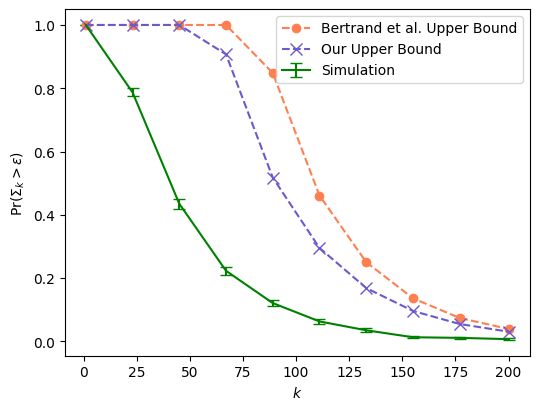

In [6]:
#Plotting

fig = plt.figure(figsize=(6,4.5))
color1 = '#6a5acd'
color2 = '#ff7f50'
plt.errorbar(get_equidistant_points(range(1,num_generations+1)),get_equidistant_points(collapse_array[1:]), yerr = get_equidistant_points(error_bars[1:]), capsize = 4,color = 'green', label = r'Simulation')
plt.plot(get_equidistant_points(range(1,num_generations+1)),get_equidistant_points(bertrand_upper_bound(num_generations)), marker='o', linestyle='--', color = color2, label = 'Bertrand et al. Upper Bound')
plt.plot(get_equidistant_points(range(1,num_generations+1)),get_equidistant_points(our_collapse_probability_bound(num_generations)), marker='x', linestyle='--', markersize = 8, color = color1, label = 'Our Upper Bound')
plt.legend(fontsize = 10)
plt.xlabel(r'$k$')
plt.ylabel(r'$\Pr(\Sigma_k>\epsilon)$')
plt.savefig('normal_collapse_probability.png')

## N-Gram Sampling Experiments

This section generates a plot showing the fraction of the survived alphabet, represented by the expected value $E\left[\text{uniq}_k\right]/m$, across generations in a discrete distribution recursive training process. The process begins with raw text data from [Wikitext-2](https://huggingface.co/datasets/Salesforce/wikitext). We repeatedly estimate the initial distribution based on frequencies and sample from the estimated distribution.




> Corollary 1: The number of unique symbols after $k$ steps in the discrete distribution recursive training process is given by

\begin{align*}
\sum^m_{i=1} \left(1 - \exp(-n  p_{0,i}  g_k )\right) \ \leq E\left[\text{uniq}_k \right] \leq  \sum^m_{i=1} \left(1 - \exp(- n p_{0,i} g_k )\max\left(1 - 3np^2_{0,i} - 3 k p_{0,i}, 0 \right) \right)
\end{align*}


This section provides code for unigram sampling only. For bigram, 8-gram and 16-gram simulations please refer [GitHub](https://github.com/berserank/Model-Collapse/).


We first import wikitext-2 from huggingface datasets library and save it in a local file.

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset

# Define the file path where you want to save the sampled data from wikitext-2
file_path = '/content/train.txt'
word_limit = 500000

# Load the wikitext-2 dataset from Hugging Face
dataset = load_dataset('Salesforce/wikitext', 'wikitext-2-raw-v1',split='train',)

# Variable to keep track of the word count
current_word_count = 0
sampled_text = []
pbar = tqdm(total = word_limit)
# Loop through each sentence in the dataset
for sentence in dataset['text']:
    # Tokenize the sentence to count words
    words_in_sentence = sentence.split()
    sentence_word_count = len(words_in_sentence)
    pbar.update(sentence_word_count)
    # Check if adding this sentence would exceed the word limit
    if current_word_count + sentence_word_count <= word_limit:
        sampled_text.append(sentence)
        current_word_count += sentence_word_count
    else:
        # If adding the full sentence would exceed the limit, add part of it to reach exactly 500K words
        remaining_words = word_limit - current_word_count
        sampled_text.append(" ".join(words_in_sentence[:remaining_words]))
        break

# Combine the sampled sentences into a single text
final_sampled_text = "\n".join(sampled_text)

# Write the sampled text to a file
with open(file_path, 'w') as file:
    file.write(final_sampled_text)

print(f"Sampled text saved to {file_path}")





100%|██████████| 50/50 [01:12<00:00,  1.45s/it]



  0%|          | 0/500000 [00:00<?, ?it/s]

Sampled text saved to /content/train.txt


Using the downloaded data, we conduct unigram recursive training.

Alternatively, you can use a custom training dataset by replacing `file_path ` with the path to your text file.

In [ ]:
file_path = '/content/train.txt'

num_trajectories = 5 #Total nunmber of trajectories
num_generations = 10 #Total nunmber of generations

A few helper functions that are used in cleaning, tokenizing the text and calculating frequencies.

In [ ]:
import re
from collections import Counter

def tokenize(text):
    '''
    Cleans and Tokenizes text into words
    '''
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)
    return text.split()

def tokenize_ngrams(text, n):
    '''
    Cleans and Tokenizes text into n-grams
    '''
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)
    words = text.split()
    ngrams = [tuple(words[i:i+n]) for i in range(len(words)-n+1)]

    return ngrams

def compute_ngram_distribution(file_path,n):
    '''
    Computes n-grams and creates a dictionary of frequencies
    '''
    if type(file_path) == str:
      try:
          with open(file_path, 'r', encoding='utf-8') as file:
              text = file.read()
          words = tokenize_ngrams(text,n)
          word_counts = Counter(words)
          return word_counts
      except FileNotFoundError:
          print(f"File not found: {file_path}")
          return {}
    else:
      word_counts = Counter(file_path)
      return word_counts


def plot_ngram_distribution(word_counts,n,generation):
    '''
    Plots the frequency distribution of n-grams
    '''

    frequency_of_frequencies = Counter(word_counts.values())

    frequencies = list(frequency_of_frequencies.keys())
    counts = [frequency_of_frequencies[freq] for freq in frequencies]

    plt.figure(figsize=(10, 6))
    plt.bar(frequencies, counts,width=1.0, edgecolor="black")
    plt.xlabel('Number of Occurrences')
    plt.ylabel('Number of Unigrams')
    plt.title(f'{n}-gram Frequency Distribution (Generation - {generation})')
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True)
    plt.show()

def compute_ngram_probability_distribution(file_path,n):
    '''
    Computes the probability distribution of n-grams from a given file
    '''
    if type(file_path) == str:
      try:
          with open(file_path, 'r', encoding='utf-8') as file:
              text = file.read()
          words = tokenize_ngrams(text,n)
          word_counts = Counter(words)
          total_unigrams = sum(word_counts.values())
          unigram_distribution = {word: count / total_unigrams for word, count in word_counts.items()}

          return unigram_distribution, total_unigrams
      except FileNotFoundError:
          print(f"File not found: {file_path}")
          return {}
    else:
       word_counts = Counter(file_path)
       total_unigrams = sum(word_counts.values())
       unigram_distribution = {word: count / total_unigrams for word, count in word_counts.items()}

       return unigram_distribution, total_unigrams


def sample_words_ngram(ngram_distribution, total):

    ngrams_as_strings = [' '.join(bigram) for bigram in ngram_distribution.keys()]
    probabilities = list(ngram_distribution.values())

    sampled_strings = np.random.choice(ngrams_as_strings, size=total, p=probabilities)

    sampled_ngrams = [tuple(s.split()) for s in sampled_strings]

    return sampled_ngrams

In [ ]:
pbar = tqdm(total=num_trajectories*num_generations)

#Simulate unigram sampling
forgotten_words = []
for _ in range(num_trajectories):
  n = 1
  word_counts = compute_ngram_distribution(file_path,n)
  probability_distribution, total = compute_ngram_probability_distribution(file_path,n)
  probabilities = list(probability_distribution.values())
  generations_to_be_forgotten = {}
  forgotten_words_constant = []
  word_counts_original = word_counts.copy()
  word_counts_constant = word_counts.copy()

  for i in range(num_generations):
    probability_distribution_constant,_ = compute_ngram_probability_distribution(word_counts_constant,n)
    sampled_words_constant = sample_words_ngram(probability_distribution_constant,total)
    word_counts_constant = compute_ngram_distribution(sampled_words_constant,n)
    forgotten_words_constant.append(len(word_counts_original) -  len(word_counts_constant))
    pbar.update(1)

  forgotten_words_constant = [i/len(word_counts) for i in forgotten_words_constant]
  forgotten_words_constant.insert(0,0)
  forgotten_words.append(forgotten_words_constant)

yerr_forgotten_words = np.std(forgotten_words, axis = 0)
forgotten_words = np.mean(forgotten_words, axis = 0)
print(f'Successfully simulated {num_trajectories} trajectories!')

500039it [00:16, 30186.53it/s]                              
100%|██████████| 50/50 [00:53<00:00,  1.65s/it]

Successfully simulated 5 trajectories!


In [ ]:
#Bounds
probabilities = list(probability_distribution.values())

#Our Bounds
def our_bounds(probabilites=probabilities, total = total,  num_generations = num_generations):
    '''
    This function calculates the bounds given in Corollary 1 in the paper.
    '''
    gok = []
    def g(x):
        return 1- np.exp(-x)
    gok.append(1)
    for i in range(1,num_generations):
        gok.append(g(gok[-1]))

    upper_bound = []
    lower_bound = []

    #Upper Bound
    for k in range(1,num_generations+1):
      temp =[1- (np.exp(-total * p * gok[k-1])*max(1-3*total*(p**2)-3*k*p,0)) for p in probabilities]
      temp = sum(temp)
      upper_bound.append(temp/len(probabilities))

    upper_bound.insert(0,1)

    #Lower Bound
    for k in range(1,num_generations+1):
      temp =[1- (np.exp(-total * p * gok[k-1])) for p in probabilities]
      temp = sum(temp)
      lower_bound.append(temp/len(probabilities))

    lower_bound.insert(0,1)

    return lower_bound, upper_bound

lower_bound, upper_bound = our_bounds()

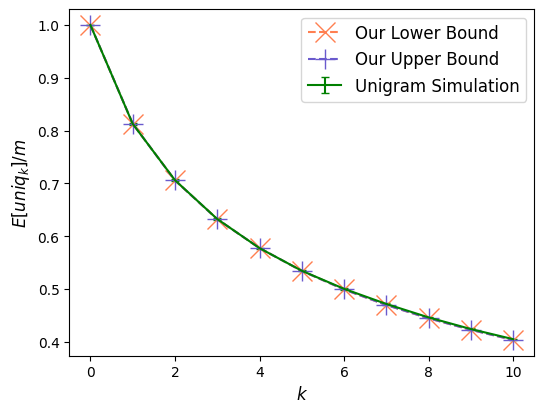

In [ ]:
#Plotting Unigram Simulations
plt.figure(figsize=(6,4.5))
color1 = '#6a5acd'
color2 = '#ff7f50'
plt.errorbar(range(11),1-np.array(forgotten_words),yerr_forgotten_words ,capsize = 3,markersize = 4,color = 'green',label = 'Unigram Simulation')
plt.plot(lower_bound,'x--',markersize = 14,label = 'Our Lower Bound', color = color2)
plt.plot(upper_bound,'+--',markersize = 14,label = 'Our Upper Bound', color = color1)
plt.legend(fontsize = 12)
plt.xlabel(r'$k$', fontsize = 12)
plt.ylabel(r'$E[uniq_k]/m$', fontsize = 12)
plt.savefig('ngram_sampling.png')
plt.show()

They coincide perfectly! For large values of n, the upper and lower bounds are very close to each other. Reducing n should create a distinction between the upper and lower bounds. To demonstrate this, we conducted an experiment with a Zipfian distribution below. Alternatively, you can decrease the `word_limit`, which directly affects the number of samples in unigram sampling."

##Zipfian Distribution

This section generates a plot showing the fraction of the survived alphabet, represented by the expected value $E\left[\text{uniq}_k\right]/m$, across generations in a discrete distribution recursive training process. The process begins with a [Zipfian distribution](https://en.wikipedia.org/wiki/Zipf%27s_law), using parameter values for $a$ and $b$.




> Corollary 1: The number of unique symbols after $k$ steps in the discrete distribution recursive training process is given by

\begin{align*}
\sum^m_{i=1} \left(1 - \exp(-n  p_{0,i}  g_k )\right) \ \leq E\left[\text{uniq}_k \right] \leq  \sum^m_{i=1} \left(1 - \exp(- n p_{0,i} g_k )\max\left(1 - 3np^2_{0,i} - 3 k p_{0,i}, 0 \right) \right)
\end{align*}



> In this setup, we begin with data sampled from a Zipfian distribution with parameters $a,b$, using an alphabet size of $m$ and drawing $n$ samples from this distribution in the initial generation.

\begin{align*}
\ p_{0,i} ∝ \frac{1}{(i+a)^b}
\end{align*}


In [ ]:
def zipf_mandelbrot(m, n, a, b):
    '''
    Samples n times from zipf distribution of alphabet size m with parameters a,b
    '''
    ranks = np.arange(1, m + 1)
    probabilities = 1 / (ranks + b) ** a
    probabilities /= probabilities.sum()
    samples = np.random.choice(ranks, size=n, p=probabilities)
    return samples

def compute_distribution(samples):
    '''
    Computes the probability distribution of samples based on frequency of unique values
    '''
    unique_values, counts = np.unique(samples, return_counts=True)
    probabilities = counts / len(samples)
    return dict(zip(unique_values, probabilities))

def sample_from_distribution(distribution):
    '''
    Samples from a given distribution
    '''
    values, probabilities = zip(*distribution.items())
    return np.random.choice(values, p=probabilities)

def sample_n_times(distribution, n):
    '''
    Samples n times from a given distribution
    '''
    return [sample_from_distribution(distribution) for _ in range(n)]

In [ ]:
#Parameters
m = 1000 #Alphabet Size
n = 1000 #Number of Samples at each generation
num_generations = 10

#Sampling

def zipf_recursive_training(a, b, m = m, n = n):
  '''
  Function to run multinomial sampling recursive training process starting with zipfian distribution.

  a: parameter for zipfian distribution
  b: parameter for zipfian distribution
  m: alphabet size
  n: number of samples at each generation

  Returns

  survived_alphabet: fraction of the survived alphabet
  std_survived_alphabet: standard deviation of the survived alphabet
  probabilities: probability distribution of the initial samples. This is used to calculate the upper and lower rbounds

  '''

  num_trajectories = 200

  # Generate Initial samples
  samples = zipf_mandelbrot(m, n, a, b)
  probability_distribution = compute_distribution(samples)
  probabilities = list(probability_distribution.values())
  temp_m = len(probabilities)
  survived_alphabet = []

  dummy_samples = samples.copy()
  dummy_probability_distribution = probability_distribution.copy()
  pbar = tqdm(total = num_generations*num_trajectories)
  #Simulate Trajectories
  for _ in range(num_trajectories):
    temp = []
    temp_samples = dummy_samples.copy()
    temp_probability_distribution = dummy_probability_distribution.copy()
    for _ in range(num_generations):
      temp_probability_distribution = compute_distribution(temp_samples)
      survived = len(list(temp_probability_distribution.keys()))
      temp.append(survived/temp_m)
      temp_samples = sample_n_times(temp_probability_distribution, n)
      pbar.update(1)
    survived_alphabet.append(temp)
  pbar.close()
  survived_alphabet = np.array(survived_alphabet)

  std_survived_alphabet = np.std(survived_alphabet, axis = 0)
  survived_alphabet = np.mean(survived_alphabet,0)


  return survived_alphabet, std_survived_alphabet, probabilities

#Our Bounds
def our_bounds(probabilites, total = n,  num_generations = num_generations):
    '''
    This function calculates the bounds given in Corollary 1 in the paper.
    '''
    gok = []
    def g(x):
        return 1- np.exp(-x)
    gok.append(1)
    for i in range(1,num_generations):
        gok.append(g(gok[-1]))

    upper_bound = []
    lower_bound = []

    #Upper Bound
    for k in range(1,num_generations):
      temp =[1- (np.exp(-total * p * gok[k-1])*max(1-3*total*(p**2)-3*k*p,0)) for p in probabilities]
      temp = sum(temp)
      upper_bound.append(temp/len(probabilities))

    upper_bound.insert(0,1)

    #Lower Bound
    for k in range(1,num_generations):
      temp =[1- (np.exp(-total * p * gok[k-1])) for p in probabilities]
      temp = sum(temp)
      lower_bound.append(temp/len(probabilities))

    lower_bound.insert(0,1)

    return lower_bound, upper_bound

In [ ]:
'''
Each element in a_b_arr is tuple (a,b) representing the zipfian parameters to experiment with.
'''
a_b_arr = [(1,2.7),(2,5)]
survived_alphabets = []
stds = []
lower_bounds = []
upper_bounds = []

for a, b in a_b_arr:
  survived_alphabet, std_survived_alphabet, probabilities = zipf_recursive_training(a = a, b = b, m = m, n = n)
  survived_alphabets.append(survived_alphabet)
  stds.append(std_survived_alphabet)
  lower_bound, upper_bound = our_bounds(probabilities)
  lower_bounds.append(lower_bound)
  upper_bounds.append(upper_bound)

100%|██████████| 2000/2000 [01:22<00:00, 24.36it/s]


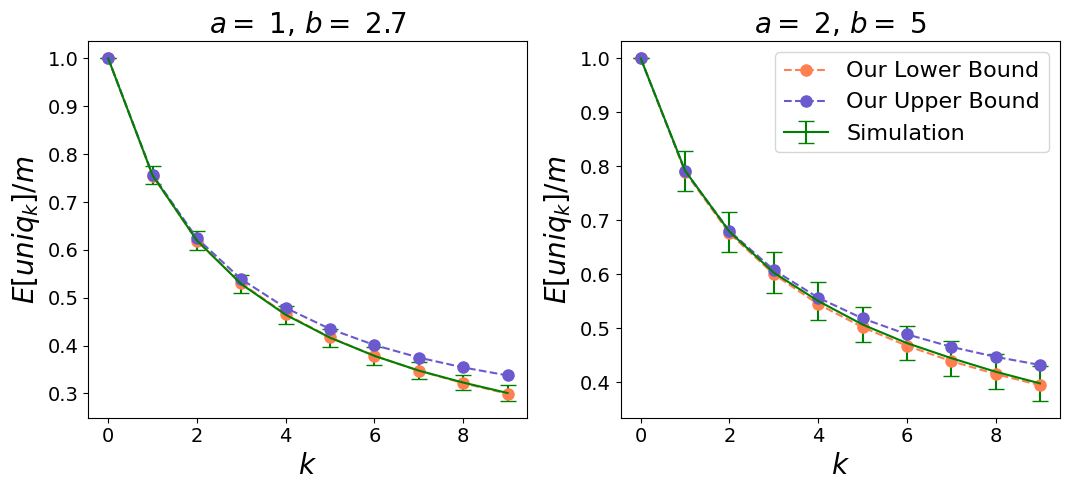

In [ ]:
#Plotting
fig, axes = plt.subplots(1, len(a_b_arr), figsize=(5.4*len(a_b_arr),5))
color1 = '#6a5acd'
color2 = '#ff7f50'
for i,ax in enumerate(axes):
 ax.errorbar(range(num_generations),survived_alphabets[i],yerr = stds[i], capsize = 6, color = 'green', label = r'Simulation')
 ax.plot(lower_bounds[i],'o--', ms = 8, label = 'Our Lower Bound', color = color2)
 ax.plot(upper_bounds[i],'o--', ms = 8,  label = 'Our Upper Bound',color = color1)
 ax.set_xlabel(r'$k$', fontsize =20)
 ax.set_ylabel(r'$E\left[uniq_k \right]/m$', fontsize =20)
 ax.set_title(r'$a = $'+f' { a_b_arr[i][0]}, $b = $'+f' { a_b_arr[i][1]}', fontsize =20)
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=14)  # Change '14' to your desired size
plt.tight_layout()
ax.legend(fontsize = 16)
plt.savefig('multinomial_sampling_zipfian.png')
plt.show()

## Gaussian Mixture Model Bounds



**Comparison of Theoretical Bounds and Empirical Observations in the Gaussian Mixture Model**

This section presents a comparison between the theoretical bounds and empirical observations of the $\Pr(\Sigma_k>\epsilon)$ at a specific generation in a GMM recursive training process using Joint and approximate ML estimators.



> **Theorem 4:**  

For the GMM recursive training process defined above with the approximate joint ML estimator given in Algorithm 1 of Appendix E, we have,
    \begin{equation*}
        \text{Pr}(\Sigma_k>\epsilon)\le \frac{\sigma_0}{\epsilon}\exp\left\{\frac{-k}{4n}\right\}.
    \end{equation*}




Helper Functions

In [7]:
def get_equidistant_points(data, num_points=10):
    data = np.asarray(data)
    if num_points > len(data):
        raise ValueError("num_points must not exceed the number of elements in data.")

    indices = np.linspace(0, len(data) - 1, num=num_points, dtype=int)

    return data[indices]

Joint ML estimator

In [8]:
#Joint ML estimation equations
def mlderiv(t1,s,n):
    '''
    Equations for Joint-ML estimation
    '''
    t2 = 1/np.maximum(np.average(s*s)-t1*t1,1e-20)
    return np.sum(s*np.tanh(t1*t2*s)) - n*t1

def mu_ml(x,al):
    return np.average(x*np.tanh(x/np.maximum(al,1e-20)))

def jointml(x):
    m2 = np.average(x*x)
    alstar,infodict,ier,mesg = sopt.fsolve(lambda al: mu_ml(x,al) - np.sqrt(m2+al*al/4) + al/2,0,full_output=True)
    if ier == 1:
        alstar = alstar[0]
        return mu_ml(x,alstar), alstar*mu_ml(x,alstar)
    else:
        return 0, m2

Approximate Joint ML estimator

In [9]:
def approx_joint_ml(samples, kappa):
    '''
    Function to calculate the Approximate Joint ML Estimator
     for the GMM recursive training process as shown in Algorithm 1
    '''
    samples = np.array(samples)
    mu_0_hat = np.mean(np.abs(samples))
    sigma_inf_squared = np.mean([x*x for x in samples])
    sigma_s_squared = sigma_inf_squared - mu_0_hat**2
    if sigma_inf_squared <= (1+kappa)*(mu_0_hat**2):
        a = 50
    else:
        a = (2*(1+kappa)*sigma_inf_squared)/(sigma_inf_squared-((1+kappa)*(mu_0_hat**2)))

    if sigma_inf_squared <= (2*a/(a-2))*(mu_0_hat**2):
        sigma_a_ml_squared = a*sigma_inf_squared*sigma_s_squared/(a*(mu_0_hat**2)+2*sigma_inf_squared)
    else:
        sigma_a_ml_squared = sigma_inf_squared

    mu_a_ml = np.sqrt(sigma_inf_squared-sigma_a_ml_squared)

    return mu_a_ml,np.sqrt(sigma_a_ml_squared)

First, to assess the accuracy of the approximate ML estimator, we estimate the mean and standard deviation using both estimators for the same set of samples and visualise them to see how good the approximation is.

In [10]:
nr = 100 #Number of Trajectories
ng = 2 #We only want to compare the estimators at first generatiom
n = 10 #Number of samples

#Initial Parameters
mu_0 = 2
sigma_0 = 1


mu_arr = []
sigma_arr = []


#JointML v/s ApproxML

eta = 2 #Bounding constant (can be any number > 1)
const = ((eta-1)*((n-1)/2+4*eta))/(eta*(n-1)*(n+4*eta-1))
kappa = np.exp(const)-1

pbar1 = tqdm(total = nr)
mu_joint_ml_approx_ml = [] #Array to save estimated means (Both the estimators)
sigma_joint_ml_approx_ml = [] #Array to save estimated standard deviations (Both the estimators)

mu_arr = []
sigma_arr = []
for _ in range(nr):
    mu = [mu_0]
    sig = [sigma_0]
    mix_rvs = np.random.binomial(n = 1, p = 0.5, size = ng*n) #Z's
    norm_rvs = np.random.normal(loc = 0, scale = 1, size = ng*n) #Gaussians
    for i in range(1,ng):
        X = 1 - 2 * mix_rvs[(i-1)*n:i*n]
        Z = sig[i-1] * norm_rvs[(i-1)*n:i*n]
        Y = mu[i-1] * X + Z
        t1star = sopt.fsolve(lambda t: mlderiv(t,Y,n), mu_0)
        t1star = t1star[0]
        mu_a_ml,sigma_a_ml = approx_joint_ml(Y, kappa)
        mu.append(np.abs(t1star))
        sig.append(np.sqrt(np.maximum(np.average(Y*Y)-t1star*t1star,0)))
        mu_joint_ml_approx_ml.append((mu[-1],mu_a_ml))
        sigma_joint_ml_approx_ml.append((sig[-1],(sigma_a_ml)))
    mu_arr.append(mu)
    sigma_arr.append(sig)
    pbar1.update(1)


  0%|          | 0/100 [00:00<?, ?it/s]

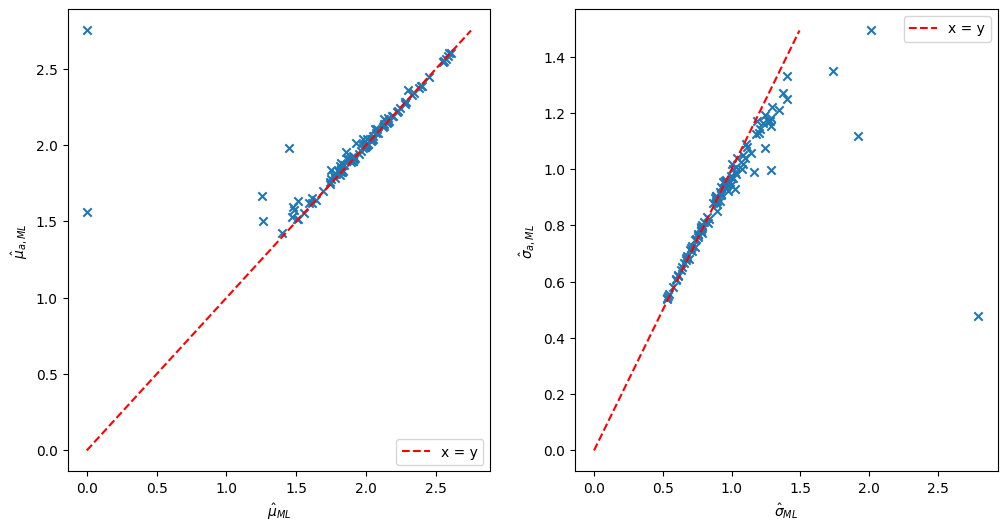

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(6*2,6))


x_vals_mu, y_vals_mu = zip(*mu_joint_ml_approx_ml)
x_vals_sigma, y_vals_sigma = zip(*sigma_joint_ml_approx_ml)

x_y_temp_mu = np.linspace(0,max(y_vals_mu),100)
x_y_temp_sigma = np.linspace(0,max(y_vals_sigma),100)


axes[0].scatter(x_vals_mu, y_vals_mu, marker = 'x', s = 36)
axes[1].scatter(x_vals_sigma, y_vals_sigma, marker = 'x', s= 36)



axes[0].plot(x_y_temp_mu, x_y_temp_mu, 'r--', label='x = y')
axes[1].plot(x_y_temp_sigma, x_y_temp_sigma, 'r--', label='x = y')


# Add labels and legend
axes[0].set_xlabel(r'$\hat{\mu}_{ML}$')
axes[0].set_ylabel(r'$\hat{\mu}_{a,ML}$')
axes[1].set_xlabel(r'$\hat{\sigma}_{ML}$')
axes[1].set_ylabel(r'$\hat{\sigma}_{a,ML}$')
axes[0].legend()
axes[1].legend()
plt.savefig(f'GMM_scatter_mu_{mu_0}.png')
plt.savefig(f'GMM_scatter_mu_{mu_0}.pdf')
plt.show()

We can see that the Approximate Joint ML estimator is pretty accurate. We can now plot the bounds for $\text{Pr}(\Sigma_k>\epsilon)$.

In [12]:
nr = 500 #Number of Trajectories
eps = 1e-1 #Collapse Threshold
ng = 200 #Number of generations
n = 10 #Number of samples at each generation
mu_0 = 1 #Initial Mean
sigma_0 = 1 #Initial Standard Deviation




#JointML

pbar1 = tqdm(total = nr)


#Simulations for recursive training using Joint ML estimator
sigma_arr = []
for _ in range(nr):
    mu = [mu_0]
    sig = [sigma_0]
    mix_rvs = np.random.binomial(n = 1, p = 0.5, size = ng*n) #Z's
    norm_rvs = np.random.normal(loc = 0, scale = 1, size = ng*n) #Gaussians
    for i in range(1,ng):
        X = 1 - 2 * mix_rvs[(i-1)*n:i*n]
        Z = sig[i-1] * norm_rvs[(i-1)*n:i*n]
        Y = mu[i-1] * X + Z
        t1star = sopt.fsolve(lambda t: mlderiv(t,Y,n), mu_0)
        t1star = t1star[0]
        mu.append(np.abs(t1star))
        sig.append(np.sqrt(np.maximum(np.average(Y*Y)-t1star*t1star,0)))
        # mu_hat,sigma_hat = jointml(Y)
        # mu.append(mu_hat)
        # sig.append(sigma_hat)
    sigma_arr.append(sig)
    pbar1.update(1)



sigma_arr = np.array(sigma_arr)
collapse_probab_joint_ml = []

for i in range(0,ng):
    count = 0
    for num in sigma_arr[:,i]:
        if num > eps:
            count += 1
    collapse_probab_joint_ml.append(count/(nr))

error_bar_joint_ml = [np.sqrt(p*(1-p)/nr) for p in collapse_probab_joint_ml]



#AprroxJointML
pbar2 = tqdm(total = nr)
eta = 2 #Bounding constant (can be any number > 1)
const = ((eta-1)*((n-1)/2+4*eta))/(eta*(n-1)*(n+4*eta-1))
kappa = np.exp(const)-1

#Simulations for recursive training using Approx Joint ML estimator
sigma_arr_approx_ml = []
for _ in range(nr):
    mu = [mu_0]
    sig = [sigma_0]
    mix_rvs = np.random.binomial(n = 1, p = 0.5, size = ng*n) #Z's
    norm_rvs = np.random.normal(loc = 0, scale = 1, size = ng*n) #Gaussians
    for i in range(1,ng):
        X = 1 - 2 * mix_rvs[(i-1)*n:i*n]
        Z = sig[i-1] * norm_rvs[(i-1)*n:i*n]
        Y = mu[i-1] * X + Z
        mu_hat,sigma_hat = approx_joint_ml(Y, kappa)
        mu.append(mu_hat)
        sig.append(sigma_hat)
    sigma_arr_approx_ml.append(sig)
    pbar2.update(1)

sigma_arr_approx_ml = np.array(sigma_arr_approx_ml)
collapse_probab_approx_ml = []

for i in range(0,ng):
    count = 0
    for num in sigma_arr_approx_ml[:,i]:
        if num > eps:
            count += 1
    collapse_probab_approx_ml.append(count/(nr))

error_bar_approx_ml = [np.sqrt(p*(1-p)/nr) for p in collapse_probab_joint_ml]



100%|██████████| 100/100 [00:08<00:00, 11.85it/s]
<ipython-input-12-646c4582a033>:27: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  t1star = sopt.fsolve(lambda t: mlderiv(t,Y,n), mu_0)


  0%|          | 2/500 [00:00<00:36, 13.54it/s]

  1%|          | 4/500 [00:00<00:38, 12.77it/s]

  1%|          | 6/500 [00:00<00:35, 13.93it/s]

  2%|▏         | 8/500 [00:00<00:37, 13.17it/s]

  2%|▏         | 10/500 [00:00<00:35, 13.68it/s]

  2%|▏         | 12/500 [00:00<00:33, 14.57it/s]

  3%|▎         | 14/500 [00:01<00:38, 12.52it/s]

  3%|▎         | 16/500 [00:01<00:36, 13.37it/s]

  4%|▎         | 18/500 [00:01<00:35, 13.74it/s]

  4%|▍         | 20/500 [00:01<00:40, 11.87it/s]

  4%|▍         | 22/500 [00:01<00:38, 12.28it/s]

  5%|▍         | 24/500 [00:01<00:37, 12.68it/s]

  5%|▌         | 26/500 [00:01<00:35, 13.53it/s]

  6%|▌         | 28/500 [00:02<00:32, 14.53it/s]

  6%|▌         | 30/500 [00:02<00:30

We now calculate the bounds as shown in Theorem 4

In [13]:
#Bounds
def our_bounds_probability(num_generations = ng, n = 10, sigma_0 = 1, eps = eps):
  bound = []
  for k in range(1,ng+1):
    a = np.exp(-k/(4*(n)))
    b = (sigma_0/eps)
    if a*b < 1:
      bound.append(a*(b))
    else:
      bound.append(1)
  return bound

upper_bound = our_bounds_probability()


Plotting the simulation results and bound

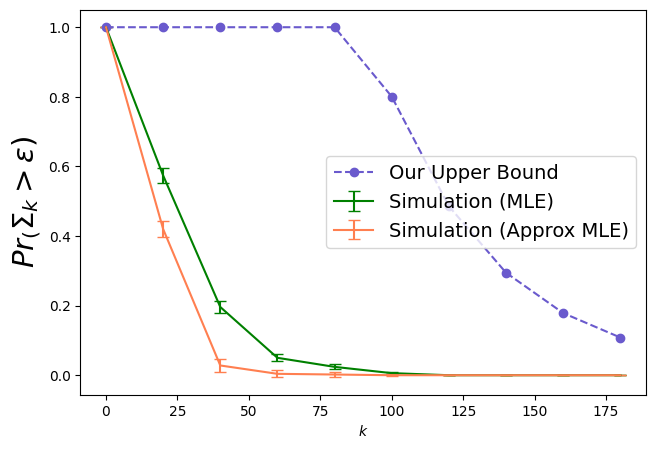

In [14]:
color1 = '#6a5acd'
color2 = '#ff7f50'
fig = plt.figure(figsize=(7.3,5))
dist = 20
plt.tight_layout(rect=[0,0,1,1])
plt.errorbar(range(0,ng)[::dist], collapse_probab_joint_ml[::dist], yerr = error_bar_joint_ml[::dist],  capsize=4,    color = 'green', label = 'Simulation (MLE)')
plt.errorbar(range(0,ng)[::dist], collapse_probab_approx_ml[::dist], yerr = error_bar_approx_ml[::dist],  capsize=4,    color=color2, label = 'Simulation (Approx MLE)')
plt.plot(range(0,ng)[::dist],upper_bound[::dist], '--', marker='o', color=color1, label = 'Our Upper Bound')
plt.legend(ncol=1, fontsize = 14)
plt.xlabel(r'$k$')
plt.ylabel(r'$Pr_(\Sigma_k>\epsilon)$', fontsize = 21)
plt.savefig(f'GMM_collapse_prob.png')
plt.savefig(f'GMM_collapse_prob.pdf')
plt.show()